# Examples

## Contents

This notebook demonstrates how to employ sforecast (sliding window) to fit an ML Model (out-of-sample train/test) and make predictions (future forecasts). Sforecast supports three model types - classical forecast models, SK learn models such as XGBoost, and Tensorflow. 

For the case of SK Learn and TensorFlow, the models are defined externally to sforecast, and thus a reference to the model is passed into sforecast. For the classical forecasting models (ARIMA, SARIMAX, AUTOARIMA), the model parameters are passed into sforecast. 

The notebook demonstrates examples for each of these model types and therein working with univariate and multivariate data, exogenous variables, endogenous variables, and categorical variables.

The scope of the notebook demonstrates the mechanics of setting up and running the corresponding data and models. Mathematical, statistical, and interpretation discussions are out of the scope. 

1. Classical Forecasting Models 
   * ARIMA
   * SARIMAX
   * Auto ARIMA  

2. SK Learn ML Models
   * Superstore Data
   * Transforming to Wide Data Format
   * Univariate with XGBoost
   * Multivariate wit exogenous, endogenous, and multiple outputs

3. TensorFlow DL Models
   * M5 Walmart Sales Data, 7 Items
   * Univariate Deep Learning
   * Multivariate + Exogenous + Endogenous + Categorical Embeddings, Multiple Output 

Several additional examples are included in the Github notebooks folder

## Initialize Notebook

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
datapath = "../data"


2024-06-17 07:40:22.348257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


sforecast version = 0.5.9


## 1. Classical Models

### ARIMA, Shampoo Sales

load data

df_shampoo.shape = (36, 2)


,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


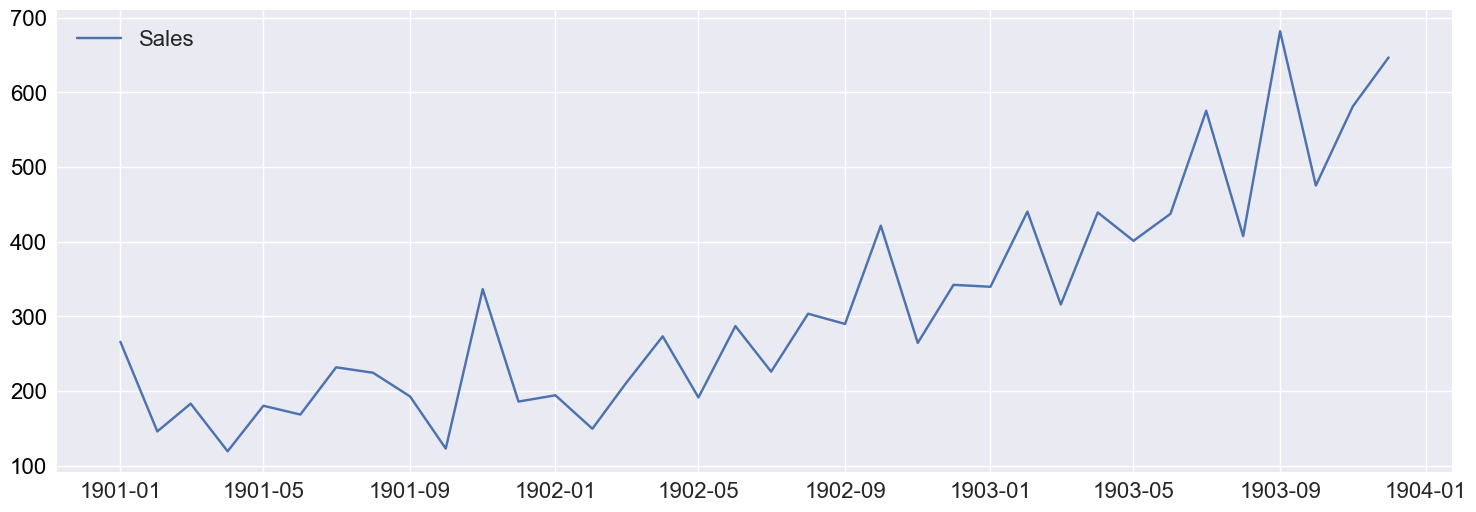

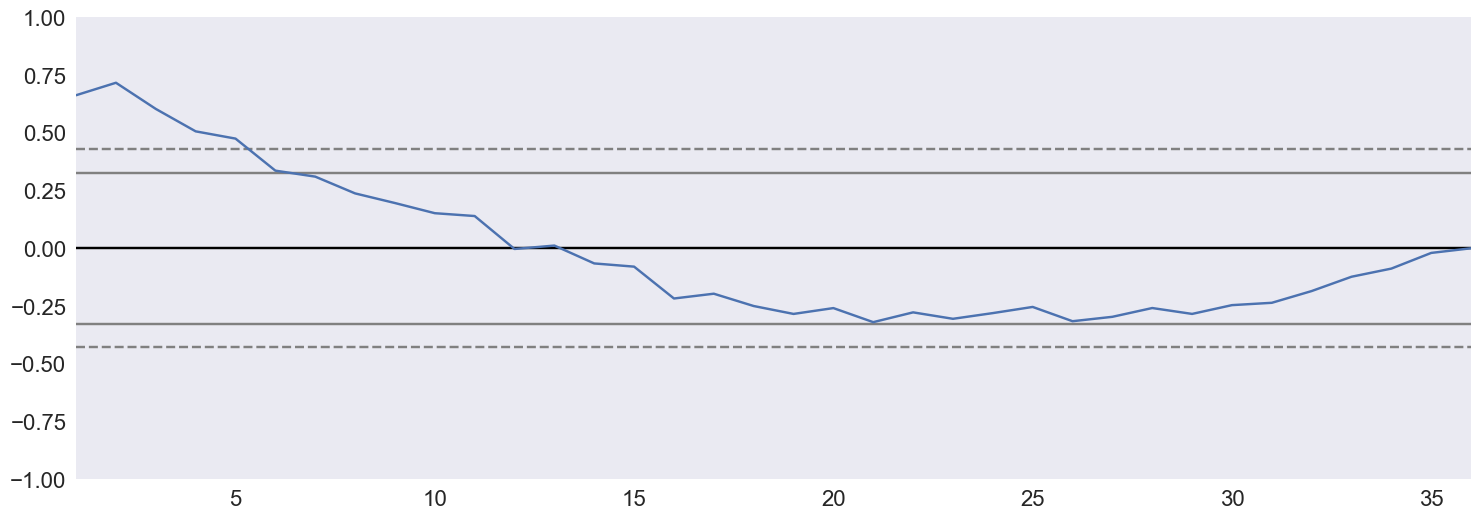

In [15]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ ... date parser and dataset
def dateparser(x):
    return datetime.strptime('190'+x, '%Y-%m')

df_shampoo = pd.read_csv(f'{datapath}/shampoo.csv', parse_dates = ["Month"], date_parser=dateparser)
print("df_shampoo.shape =",df_shampoo.shape)
display(df_shampoo.head())
bp.lineplot(df_shampoo, x = "Month", y="Sales", figsize=(18,6), y_axis_format=".0f")

# Plot Sales Autocorrelation
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(18,6)) 
g=autocorrelation_plot(df_shampoo["Sales"])

plot_options = bp.plot_defaults()
bp.set_axisparams(plot_options,ax,g)
plt.show()


Fit - ARIMA sliding 5 period forecast

dfXY


,Sales
0,266.0
1,145.9
2,183.1
3,119.3
4,180.3



metrics = {'Sales_pred': {'RMSE': 96.4139361648774, 'MAE': 78.28000065334483}}


,Month,Sales,Sales_train,Sales_test,Sales_pred,Sales_pred_error,Sales_pred_lower,Sales_pred_upper
31,1903-08-01,407.6,NaN,407.6,467.811682,60.211682,321.109698,517.812587
32,1903-09-01,682.0,NaN,682.0,519.261277,-162.738723,372.559293,569.262182
33,1903-10-01,475.3,NaN,475.3,464.182016,-11.117984,317.480032,514.182921
34,1903-11-01,581.3,NaN,581.3,615.984739,34.684739,469.282755,665.985644
35,1903-12-01,646.9,NaN,646.9,524.253124,-122.646876,377.551140,574.254029


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -200.188
Date:                Sat, 15 Jun 2024   AIC                            406.376
Time:                        07:28:51   BIC                            411.042
Sample:                             0   HQIC                           407.987
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9139      0.225     -4.067      0.000      -1.354      -0.473
ar.L2         -0.2630      0.189     -1.392      0.164      -0.633       0.107
sigma2      5311.7175   1383.504      3.839      0.0

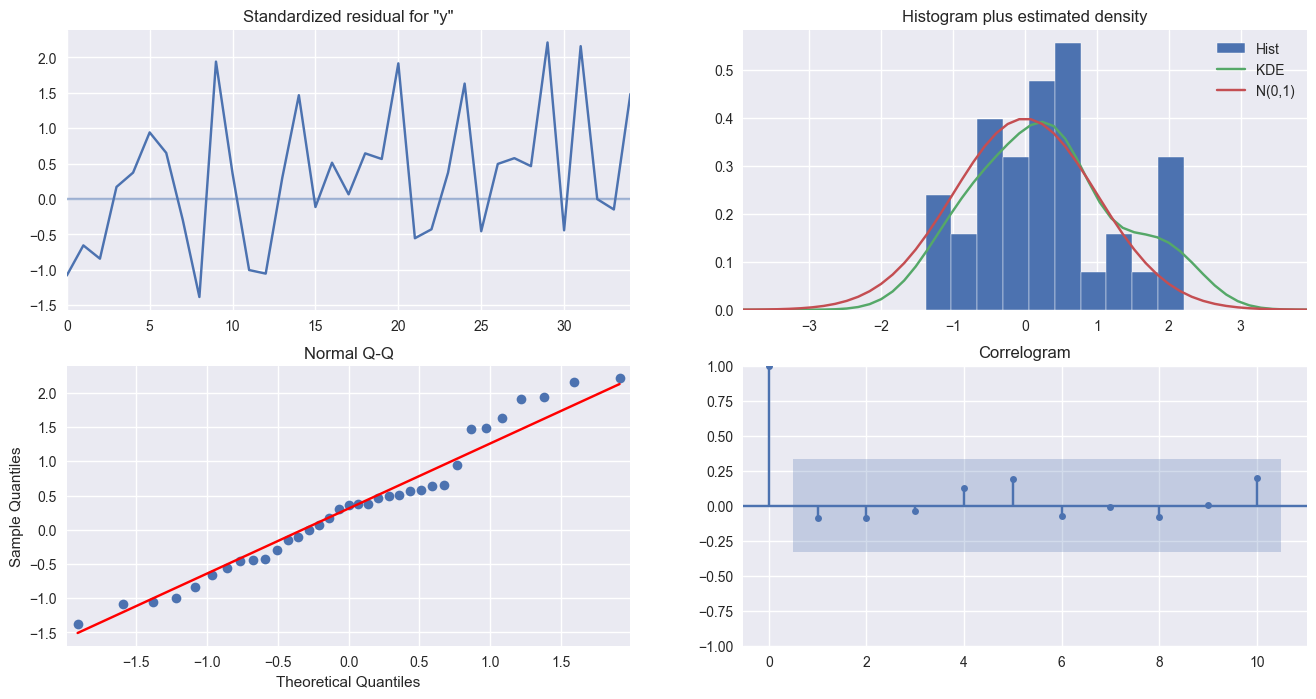

In [16]:
Ntest = 5
y=["Sales"]
dfXY = df_shampoo[y]
print('dfXY')
display(dfXY.head())

swin_params = {
    "Ntest":Ntest,
    "Nlags": 5,
    "minmax" :(0,None)}  

cm_parameters = {
    "model":"arima",
    "order":(2,1,0)
}

sf_arima = sf.sliding_forecast (y = y,
                    model=None,
                    model_type="cm", 
                    cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_arima = sf_arima.fit(dfXY)

print(f'\nmetrics = {sf_arima.metrics}')
dfXY_pred_arima = df_shampoo.join(df_pred_arima)
display(dfXY_pred_arima.tail(Ntest))

print(sf_arima.model_fit.summary())

sf_arima.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

plot observations and predictions with beautifulplots.lineplot

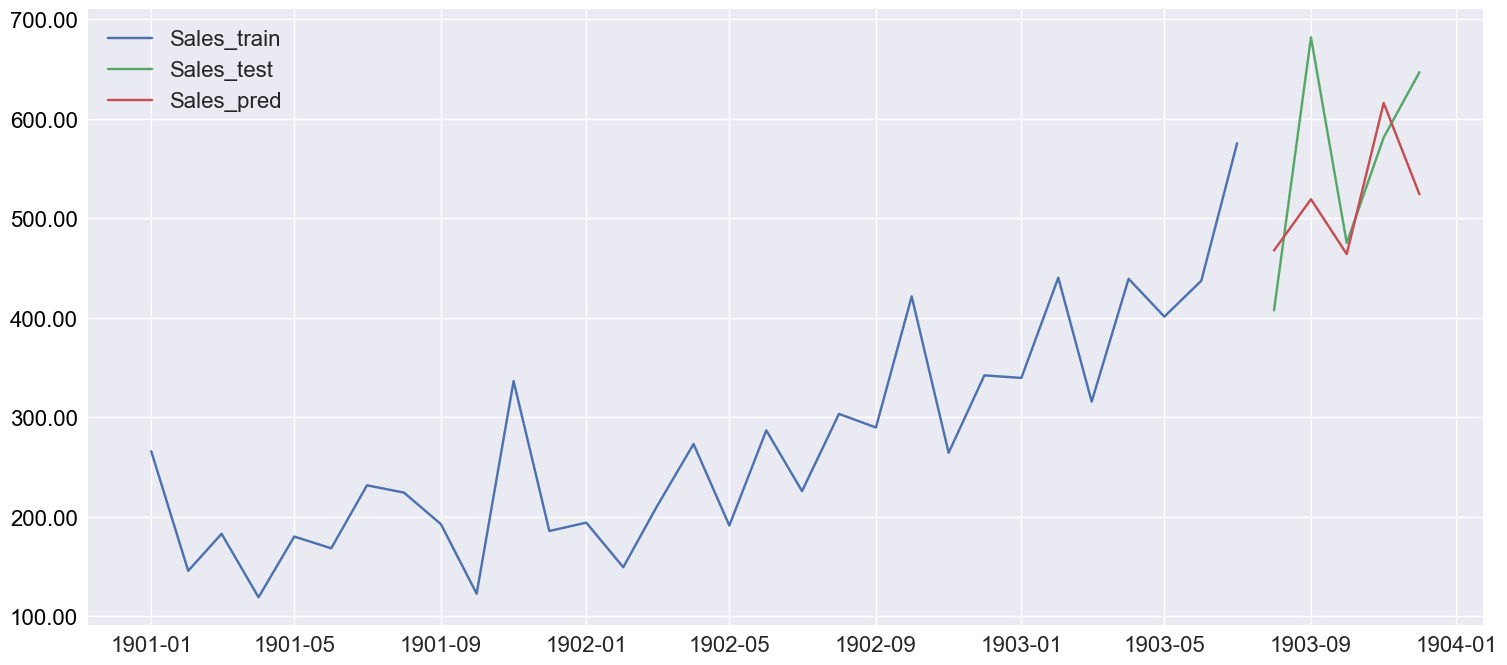

In [17]:

ytrain = y[0]+"_train"
ytest = y[0]+"_test"
ypred = y[0]+"_pred"
error = y[0]+"_pred_error"

bp.lineplot(dfXY_pred_arima, x= "Month", y=[ytrain, ytest , ypred] , figsize=(18,8))

Predict - based on the previously fitted model

In [20]:

ts_period = pd.DateOffset(months=1)
df_pred=sf_arima.predict(Nperiods=1)
df_pred

,Sales_pred
36,559.074667


### SARIMAX

load data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


rows with NA


,Passengers
Month,


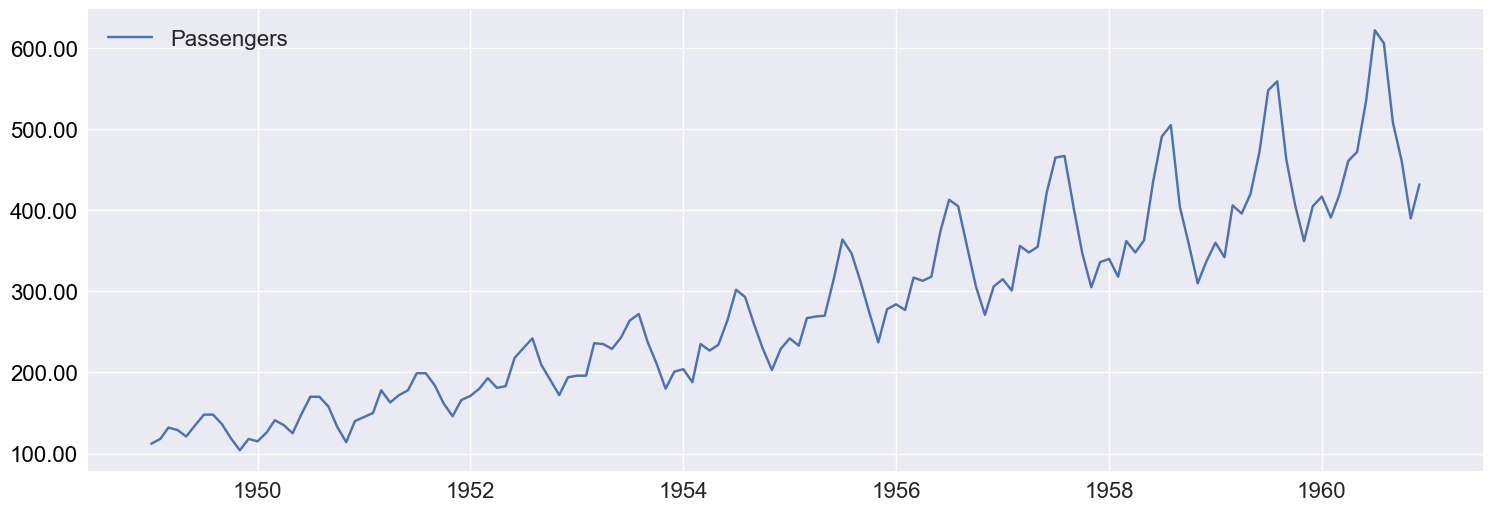

In [21]:
#data
#https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download

df_airp = pd.read_csv(f'{datapath}/AirPassengers.csv', parse_dates = ["Month"]).set_index("Month")
display(df_airp.head())

# rows with NA
print("rows with NA")
display(df_airp[df_airp.isna().any(axis=1)])

bp.lineplot(df_airp.reset_index(), x="Month", y=["Passengers"], figsize=(18,6))

**Sarimax w/o exogenous or endogenous/derived variables**

dfXY


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121



metrics = {'Passengers_pred': {'RMSE': 16.743097882478537, 'MAE': 15.244803513154238}}


,Passengers,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,
1960-08-01,606,NaN,606.0,630.137901,24.137901,628.589746,653.908643
1960-09-01,508,NaN,508.0,518.765675,10.765675,517.217519,542.536416
1960-10-01,461,NaN,461.0,452.211668,-8.788332,450.663512,475.982410
1960-11-01,390,NaN,390.0,413.220001,23.220001,411.671846,436.990743
1960-12-01,432,NaN,432.0,441.312108,9.312108,439.763953,465.082850


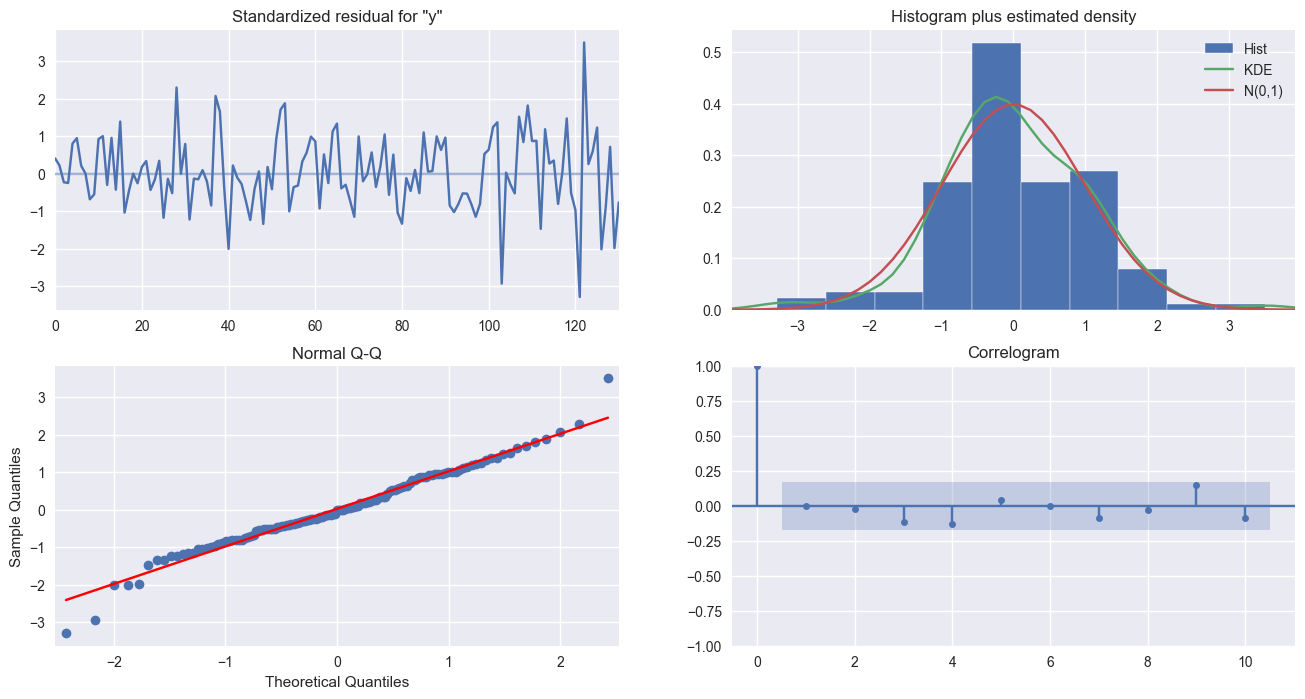

In [22]:

Ntest=5
dfXY = df_airp[["Passengers"]]
print('dfXY')
display(dfXY.head())

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = "Passengers"
sf_sarimax = sf.sliding_forecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()


**Predict Sarimax no exogs**

In [23]:
ts_period = pd.DateOffset(months=1)
df_pred=sf_sarimax.predict(Nperiods=1,ts_period=ts_period)
df_pred

,Passengers_pred
1961-01-01,444.327801


**Exogenous Variables**

These variables are not dependent and are ususally some form of external varialbe. For example, they could represent the weather, such as temperature or rain, or economic data, such as consumer confience index.

The variables are included in the input dataframe to the fit operation. An exogenous variables dataframe, one row per predict period (i.e., index), is input to the predict operation.

Below is trivial example of exogenous variables, the month number is included as an exogenous variable input. df_airp has two variables the target variable and y = Passengers, and exogenous variable month_no

In [24]:
# add exogenous variable "month_no"
# df_airp has two variables the target variable y = Passengers, 
# and exogenous variable month_no

dfXY = df_airp.copy()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

display(dfXY)

,Passengers,month_no
Month,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5
...,...,...
1960-08-01,606,8
1960-09-01,508,9
1960-10-01,461,10


**Saramax w/ Exogs**

,Passengers,month_no
Month,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5



metrics = {'Passengers_pred': {'RMSE': 15.309241439681522, 'MAE': 13.773480924095225}}


,Passengers,month_no,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,,
1960-08-01,606,8,606.0,NaN,NaN,NaN,NaN,NaN
1960-09-01,508,9,508.0,NaN,NaN,NaN,NaN,NaN
1960-10-01,461,10,NaN,461.0,452.211667,-8.788333,447.043422,472.650089
1960-11-01,390,11,NaN,390.0,413.220001,23.220001,408.051756,433.658424
1960-12-01,432,12,NaN,432.0,441.312108,9.312108,436.143863,461.750531


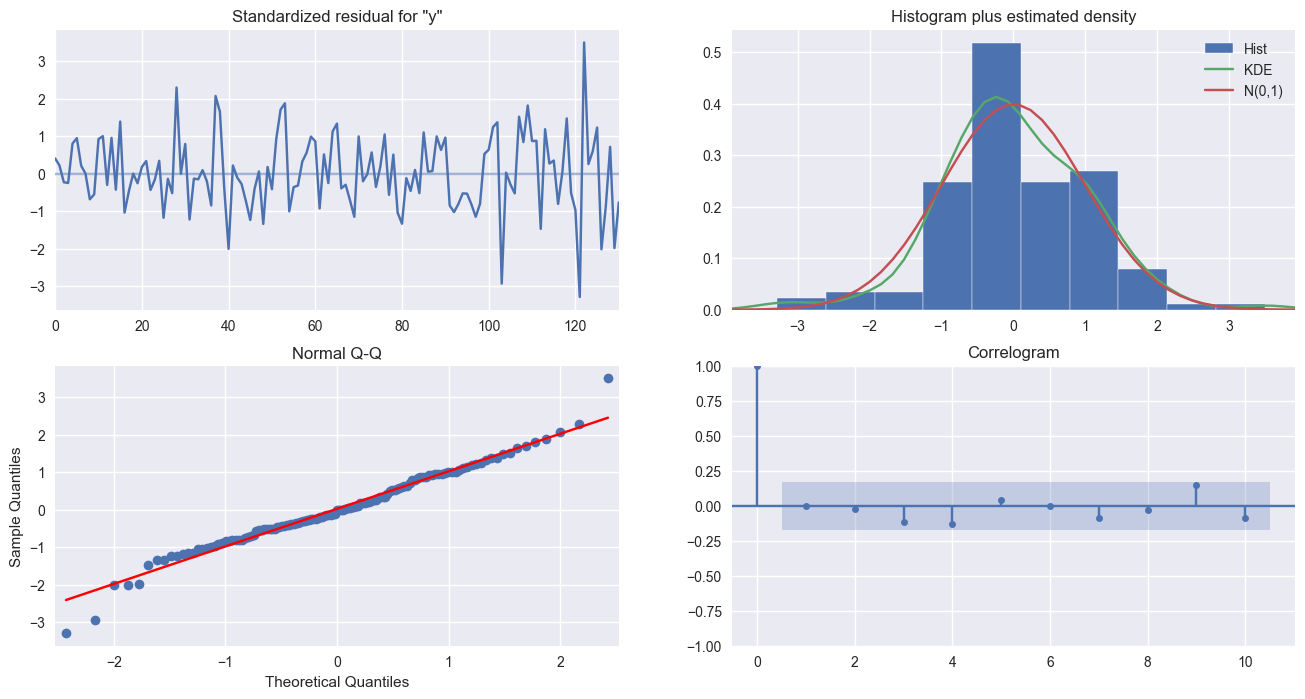

In [25]:
Ntest = 3
display(dfXY.head())

exogvars = ["month_no"]

swin_parameters = {
    "Ntest":Ntest,
    "Nlags":5,
    "minmax" :(0,None),
    "Nhorizon":1,
    "exogvars": exogvars
    }

cm_parameters = {
    "model":"sarimax",
    "order":(2,1,0),
    "seasonal_order":(0,1,0,12)
    }

y = "Passengers"
sf_sarimax = sf.sliding_forecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_parameters,)

df_pred_sarimax = sf_sarimax.fit(dfXY)

print(f'\nmetrics = {sf_sarimax.metrics}')
dfXY_pred_sarimax = dfXY.join(df_pred_sarimax)
display(dfXY_pred_sarimax.tail())

sf_sarimax.model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

**predict sarimax w/ exogs**

In [26]:
ts_period = pd.DateOffset(months=1)
dfexogs = pd.DataFrame(data={"month_no":[1]})
df_pred=sf_sarimax.predict(Nperiods=1,dfexogs = dfexogs, ts_period=ts_period)
df_pred

,Passengers_pred
1961-01-01,444.327802


### Auto ARIMA

exenvars = None ... without exogvars and without derived attributes

In [27]:
Ntest = 4
Nhorizon = 2
dfXY = df_airp
print("dfXY.index.size = ", dfXY.index.size)
print('dfXY.tail()')
display(dfXY.tail())


swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon": Nhorizon,
    "minmax" :(0,None)
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = "Passengers"
sf_autoarima = sf.sliding_forecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

print("confidence intervals = ",sf_autoarima.ci )
dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())


dfXY.index.size =  144
dfXY.tail()


,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=999.041, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=988.030, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=988.606, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=987.497, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=988.367, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=989.465, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=989.427, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=987.923, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=985.987, Time=0.11 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=986.643, Time=0.32 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=986.912, Time=0.38 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=98

,Passengers,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,
1960-08-01,606,606.0,NaN,NaN,NaN,NaN,NaN
1960-09-01,508,NaN,508.0,514.690165,6.690165,522.978996,535.768317
1960-10-01,461,NaN,461.0,455.350909,-5.649091,452.359333,473.619452
1960-11-01,390,NaN,390.0,412.676817,22.676817,420.965648,433.754969
1960-12-01,432,NaN,432.0,452.926058,20.926058,449.934482,471.194601


**predict autoarima**

In [28]:

ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=3, ts_period=ts_period)
df_pred

,Passengers_pred
1961-01-01,451.347077
1961-02-01,427.102222
1961-03-01,463.382490


**Auto Arima with Exogenous Variables**

In [29]:
Ntest = 3
Nhorizon = 3
dfXY = df_airp.copy()

# Exogenous variables
dfXY["month_no"] = dfXY.index.month # exog variable

print('dfXY')
display(dfXY.head())

exogvars = ["month_no"]

swin_params = {
    "Ntest":Ntest,
    "Nlags":5,
    "Nhorizon":Nhorizon,
    "minmax" :(0,None),
    "exogvars": exogvars,
    }  

cm_parameters = {
    "model":"auto_arima",
    "d":None, # let the auto search determine d
    "start_p":1,
    "start_q":1,
    "seasonal":True ,
    "D":None, # let auto search determine D
    "m":12, # 12, period (i.e., month) seasonality period
    "start_P":1,
    "start_Q":1,
    "error_action":"ignore", # don't want to know if order does not work
    "suppress_warnings":True, # don't want convergence warnings
    "stepwise":True # stepwise search
}

y = "Passengers"
sf_autoarima = sf.sliding_forecast(y = y, model=None, model_type="cm", cm_parameters=cm_parameters,
                    swin_parameters=swin_params,)

df_pred_autoarima = sf_autoarima.fit(dfXY)

print(f'\nmetrics = {sf_autoarima.metrics}')

dfXY_pred_autoarima = dfXY.join(df_pred_autoarima)
display(dfXY_pred_autoarima.tail())

dfXY


,Passengers,month_no
Month,,
1949-01-01,112,1
1949-02-01,118,2
1949-03-01,132,3
1949-04-01,129,4
1949-05-01,121,5


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1005.914, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=995.467, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=995.933, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=995.060, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=995.871, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=997.033, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=996.991, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=995.306, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=993.005, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=993.546, Time=0.34 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=993.857, Time=0.36 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=9

,Passengers,month_no,Passengers_train,Passengers_test,Passengers_pred,Passengers_pred_error,Passengers_pred_lower,Passengers_pred_upper
Month,,,,,,,,
1960-08-01,606,8,606.0,NaN,NaN,NaN,NaN,NaN
1960-09-01,508,9,508.0,NaN,NaN,NaN,NaN,NaN
1960-10-01,461,10,NaN,461.0,451.130222,-9.869778,441.260444,441.260444
1960-11-01,390,11,NaN,390.0,405.185239,15.185239,420.370478,420.370478
1960-12-01,432,12,NaN,432.0,447.437675,15.437675,462.875350,462.875350


**autoarima predict with exogvars**

In [30]:

dfexogs = pd.DataFrame(data = {"month_no":[1,2,3,4,5]})
print("dfexogs")
display(dfexogs)
ts_period = pd.DateOffset(months=1)
df_pred=sf_autoarima.predict(Nperiods=3,dfexogs=dfexogs, ts_period=ts_period)
df_pred

dfexogs


,month_no
0,1
1,2
2,3
3,4
4,5


,Passengers_pred
1961-01-01,451.347077
1961-02-01,427.102222
1961-03-01,463.382490


## 2. SK Learn Models

### Superstore Data

Often data needs pre-processing in the form of aggregattions and cleansing so that it is suitable for forecasting. The data for these examples is derived from the Superstore dataset avaliable [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls). In order to not over complicate this notebook we will not demonstrate all the pre-processing here. Howevver, for reference, all the details are contaned in the EDA/pre-procssing notebook  - [pre-processing notebook](https://github.com/Aljgutier/sforecast/blob/main/docs/Superstore_data.ipynb)

Data pre-processing, prior to loading the data, includes the following steps
* contiguous dates - ensure that there are no missing dates
* the data is aggregated to sub category - the original dateset containes categories, sub-categories, and product ids. Below, we will further aggregate to category.

The output of the preprocesing (i.e., data loaded below) is avaialable in this github repo, [pre-processed data](https://github.com/Aljgutier/sforecast/blob/main/data/Superstore_subcatsales_2017_cdp.csv).

 After loading the data there are two additional steps (shown below) to prepare it for forecasting
 * The data will be aggregated to the three categories (office supplies, technology, furniture)
 * It will be transformed to wide format so that all categories are columns

All these transformations (before and after loading) typify transformations required in real situations.

Load data

In [31]:
df_sales = pd.read_csv(f'{datapath}/Superstore_subcatsales_2017_cdp.csv', parse_dates = ["Order Date"])
display(df_sales.head(10))

print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

,Order Date,Category,Sub-Category,Sales,Quantity
0,2014-01-03,Office Supplies,Paper,16.448,2.0
1,2014-01-04,Office Supplies,Labels,11.784,3.0
2,2014-01-04,Office Supplies,Binders,3.540,2.0
3,2014-01-04,Office Supplies,Paper,0.000,0.0
4,2014-01-04,Office Supplies,Storage,272.736,3.0
5,2014-01-05,Office Supplies,Labels,0.000,0.0
6,2014-01-05,Office Supplies,Binders,0.000,0.0
7,2014-01-05,Office Supplies,Paper,0.000,0.0
8,2014-01-05,Office Supplies,Art,19.536,3.0
9,2014-01-05,Office Supplies,Storage,0.000,0.0


date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


Aggregate to Category Time-Series


* aggregate category sales by date
* three categories - office supplies, furniture, technology
* lineplots to observe the timeseries

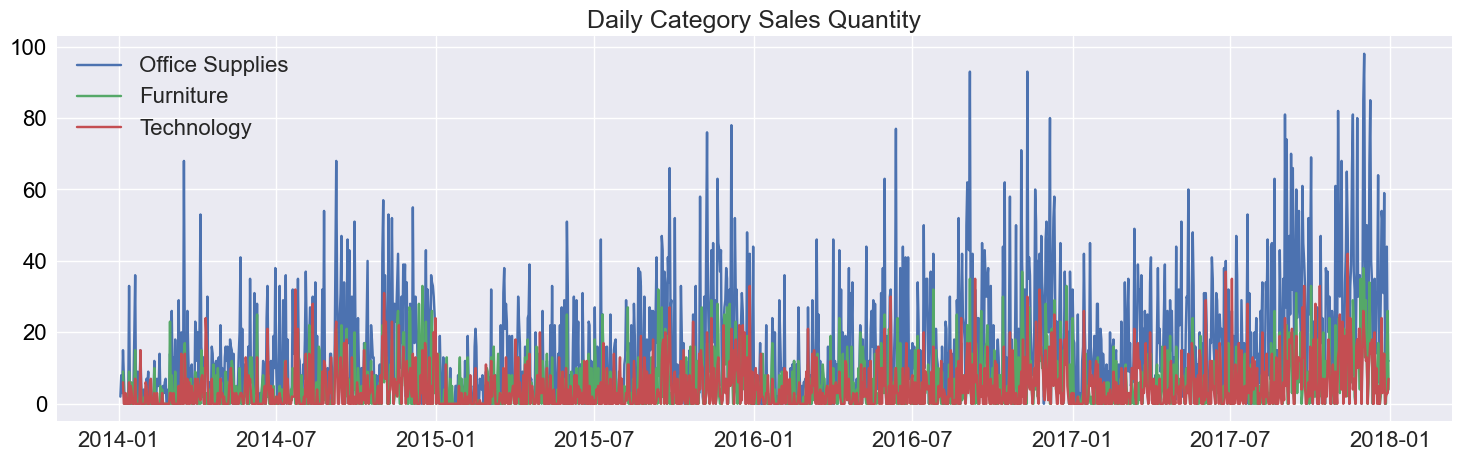

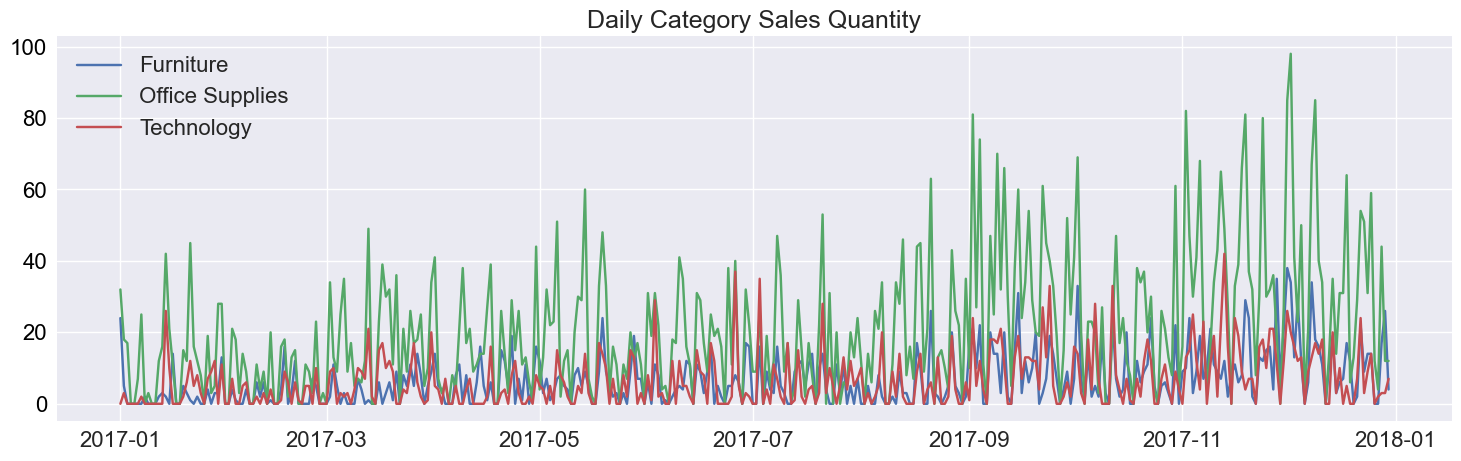

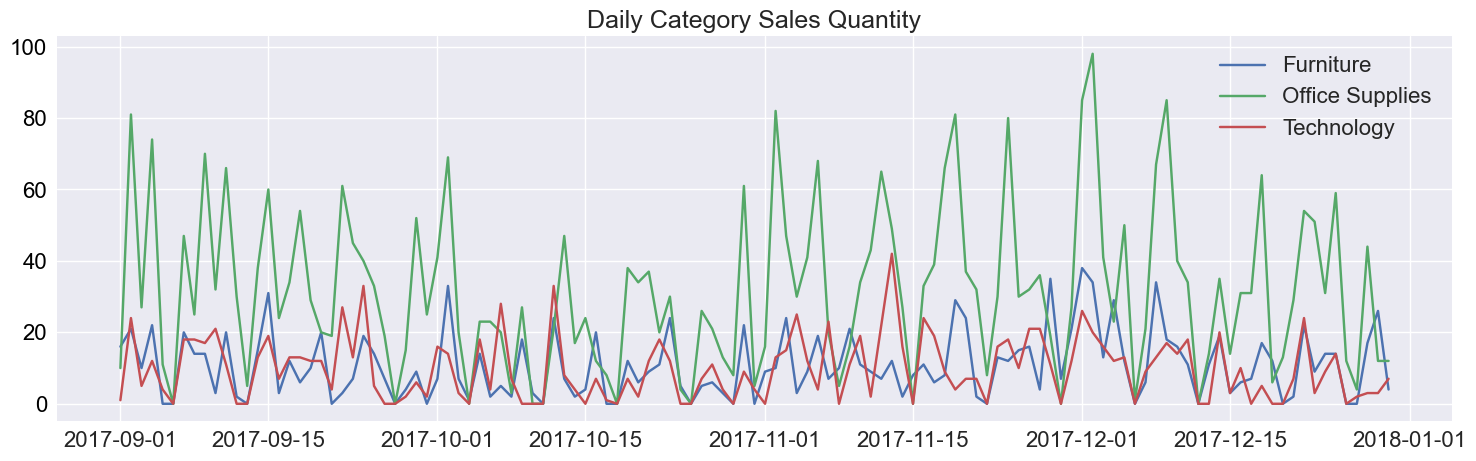

In [32]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

Wide (Multivariate) Format

* Below is a demonstration of how to pivot the DataFrame to a wide format
* * Wide format will be especially useful for accounting for exogenous variables and covariates.
  * Pivot to wide format - time (index or colum) 
  * ll variables including co-variates in corresponding columns.
* We are interested in forecasting unit sales volume, "Quantity." 
  * We do not need the sales revenue columns.

In [33]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period

# demand period (dp) = "Order Date" becomes the index
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

display(dfXYw.head(3))

display(dfXYw.tail(7))

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.0,16.448,0.0
2014-01-04,0.0,8.0,0.0,0.0,288.060,0.0
2014-01-05,0.0,3.0,0.0,0.0,19.536,0.0


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2017-12-24,14.0,31.0,9.0,1393.4940,1479.638,3359.922
2017-12-25,14.0,59.0,14.0,832.4540,1465.265,401.208
2017-12-26,0.0,12.0,0.0,0.0000,814.594,0.000
2017-12-27,0.0,4.0,2.0,0.0000,13.248,164.388
2017-12-28,17.0,44.0,3.0,551.2568,1091.244,14.850
2017-12-29,26.0,12.0,3.0,2330.7180,282.440,302.376
2017-12-30,4.0,12.0,7.0,323.1360,299.724,90.930


### Import XGBoost

In [34]:
from xgboost import XGBRegressor

### Univariate fit and predict

Univariate forecast considers only one variable
  * Slideing forecast: 30 day sliding forecast, Ntest = 30 days
  * Predict horizon:  Nhorizon = 1. The model is retrained after every Nhorizon time periods. Out-of-sample predictions are made to account for new observation after sliding over by 1 time period.
  * Target Variable: y = "Quantity_Furniture"
  * Lags: Nlags = 40. The univariate (y) will be lagged over 40 days.
  * ML model: In this case the model is an untrained XGBoost model. Generally, any SK Learn model can be input to sforecast
  * Output: DataFrame with output predictions, upper lower bounds, error wrt to target variable. Join the forecast result with the input DataFrame dfXY
  * Data scaling: By default the sliding model will scale the input variables with the SKlearn minmax scaler (normalization). However, sforecast offers the option to scale with the StandardScaler (standardization). 
  * See the [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton for more information.

In [36]:
dfXY = dfXYw[["Quantity_Furniture"]].copy()

print('dfXY')
display(dfXY.tail())

Ntest = 30
Nhorizon = 1

swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfxgbuv = sf.sliding_forecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")

df_pred_xgbuv = sfxgbuv.fit(dfXY)

print(f'\nmetrics = {sfxgbuv.metrics}')


dfXY_pred_xgbuv = dfXY.join(df_pred_xgbuv)
display(dfXY_pred_xgbuv)


dfXY


,Quantity_Furniture
Order Date,
2017-12-26,0.0
2017-12-27,0.0
2017-12-28,17.0
2017-12-29,26.0
2017-12-30,4.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 11.551833881017961, 'MAE': 9.230052280426026}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,9.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,12.570740,12.570740,0.0,20.869277
2017-12-27,0.0,NaN,0.0,4.480949,4.480949,0.0,12.779486
2017-12-28,17.0,NaN,17.0,13.771085,-3.228915,0.0,22.069622


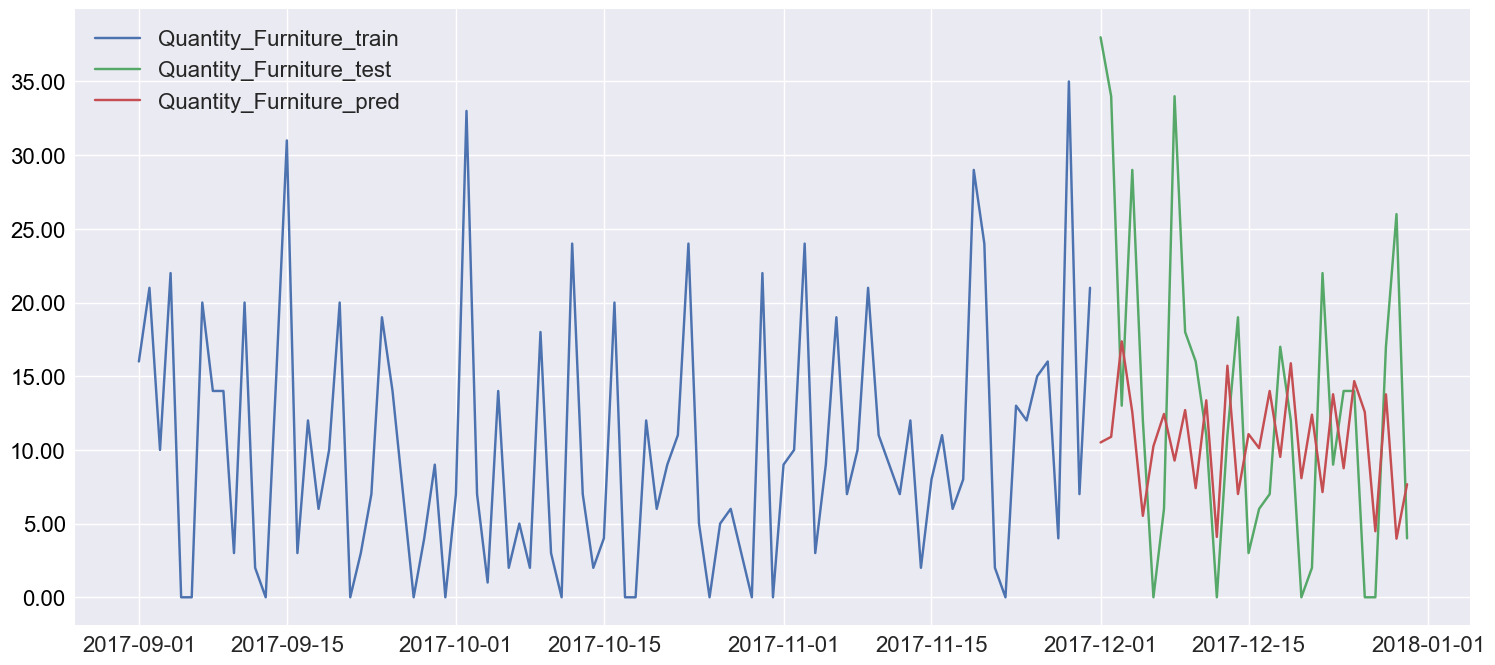

In [37]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbuv = dfXY_pred_xgbuv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbuv[dfxgbuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

**Predict XGB univariate**

In [38]:
ts_period = pd.DateOffset(days=1)
df_pred=sfxgbuv.predict(Nperiods=2,ts_period=ts_period)
df_pred

,Quantity_Furniture_pred
2017-12-31,11.969523
2018-01-01,6.577347


### Multivariate,Exogenous, Endogenous, Multiple Outputs, Nhorizon > 1

* This case is again very similar to the previous examples
* We inclue the co-variate variables and forecast co-variates
* In this case, sforecast loops through the variables
* Note, for more advanced types of models, such as deep-learning models, the multivarites forecasts can be generated simultaneously

Endogenous derived dependent attributes

In [46]:
dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0
...,...,...,...
2017-12-26,0.0,12.0,0.0
2017-12-27,0.0,4.0,2.0
2017-12-28,17.0,44.0,3.0


In [48]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "Quantity_Furniture":["mean","std"],
    "Quantity_Office Supplies": ["mean","std"],
    "Quantity_Technology": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

#---- test -----#
derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')


Nendogs = 6

derived_attriburtes = ['Quantity_Furniture_m1_mean3', 'Quantity_Furniture_m1_std3', 'Quantity_Office Supplies_m1_mean3', 'Quantity_Office Supplies_m1_std3', 'Quantity_Technology_m1_mean3', 'Quantity_Technology_m1_std3']
Nclip = 3
dataframe, dftest, with derived variables


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_m1,Quantity_Office Supplies_m1,Quantity_Technology_m1,Quantity_Furniture_m1_mean3,Quantity_Furniture_m1_std3,Quantity_Office Supplies_m1_mean3,Quantity_Office Supplies_m1_std3,Quantity_Technology_m1_mean3,Quantity_Technology_m1_std3
Order Date,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,0.0,3.0,0.0,0.000000,0.000000,4.333333,3.214550,0.000000,0.000000
2014-01-07,3.0,7.0,0.0,9.0,15.0,6.0,3.000000,5.196152,8.666667,6.027714,2.000000,3.464102
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,14.0,59.0,14.0,12.333333,2.886751,47.000000,14.422205,8.666667,5.507571
2017-12-27,0.0,4.0,2.0,0.0,12.0,0.0,9.333333,8.082904,34.000000,23.643181,7.666667,7.094599
2017-12-28,17.0,44.0,3.0,0.0,4.0,2.0,4.666667,8.082904,25.000000,29.715316,5.333333,7.571878


Nrw= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_m1,Quantity_Office Supplies_m1,Quantity_Technology_m1
Order Date,,,,,,
2017-12-28,17.0,44.0,3.0,0.0,4.0,2.0
2017-12-29,26.0,12.0,3.0,17.0,44.0,3.0
2017-12-30,4.0,12.0,7.0,26.0,12.0,3.0


In [49]:
dfXY = dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()
# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

display(dfXY.tail())

y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Ntest= 30
Nhorizon = 5

# sliding forecast inputs
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"],
    "exogvars":"dayofweek",
    "derived_attributes_transform":derived_variables_transformer # Endogenous Variables
    } 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfxgbmv = sf.sliding_forecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred_xgbmv = sfxgbmv.fit(dfXY)


print(f'\nmetrics = {sfxgbmv.metrics}')

dfXY_pred_xgbmv = dfXY.join(df_pred_xgbmv)
display(dfXY_pred_xgbmv)

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek
Order Date,,,,
2017-12-26,0.0,12.0,0.0,1
2017-12-27,0.0,4.0,2.0,2
2017-12-28,17.0,44.0,3.0,3
2017-12-29,26.0,12.0,3.0,4
2017-12-30,4.0,12.0,7.0,5



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.237966397374693, 'MAE': 8.159046093622843}, 'Quantity_Office Supplies_pred': {'RMSE': 25.272740464815477, 'MAE': 19.122392813364666}, 'Quantity_Technology_pred': {'RMSE': 8.04430011216907, 'MAE': 6.758149558305741}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,6,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,1,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,1,NaN,0.0,9.119610,9.119610,0.000000,19.766999,...,12.326706,0.326706,0.000000,18.121150,NaN,0.0,3.842882,3.842882,0.000000,13.018852
2017-12-27,0.0,4.0,2.0,2,NaN,0.0,7.249815,7.249815,0.000000,17.821237,...,5.972883,1.972883,0.000000,25.486921,NaN,2.0,5.939587,3.939587,0.000000,18.639607
2017-12-28,17.0,44.0,3.0,3,NaN,17.0,14.951090,-2.048910,0.000000,14.157401,...,33.685150,-10.314850,0.000000,26.331535,NaN,3.0,9.177584,6.177584,5.746384,14.851728


plot the observations, predicted output, and test (observations during corresponding to the predictions)

illustrate the confidence interval around the predictions. Sforecast defaults to 80% confidence periods, however the desired confidence interval can be specified as an input parameter.

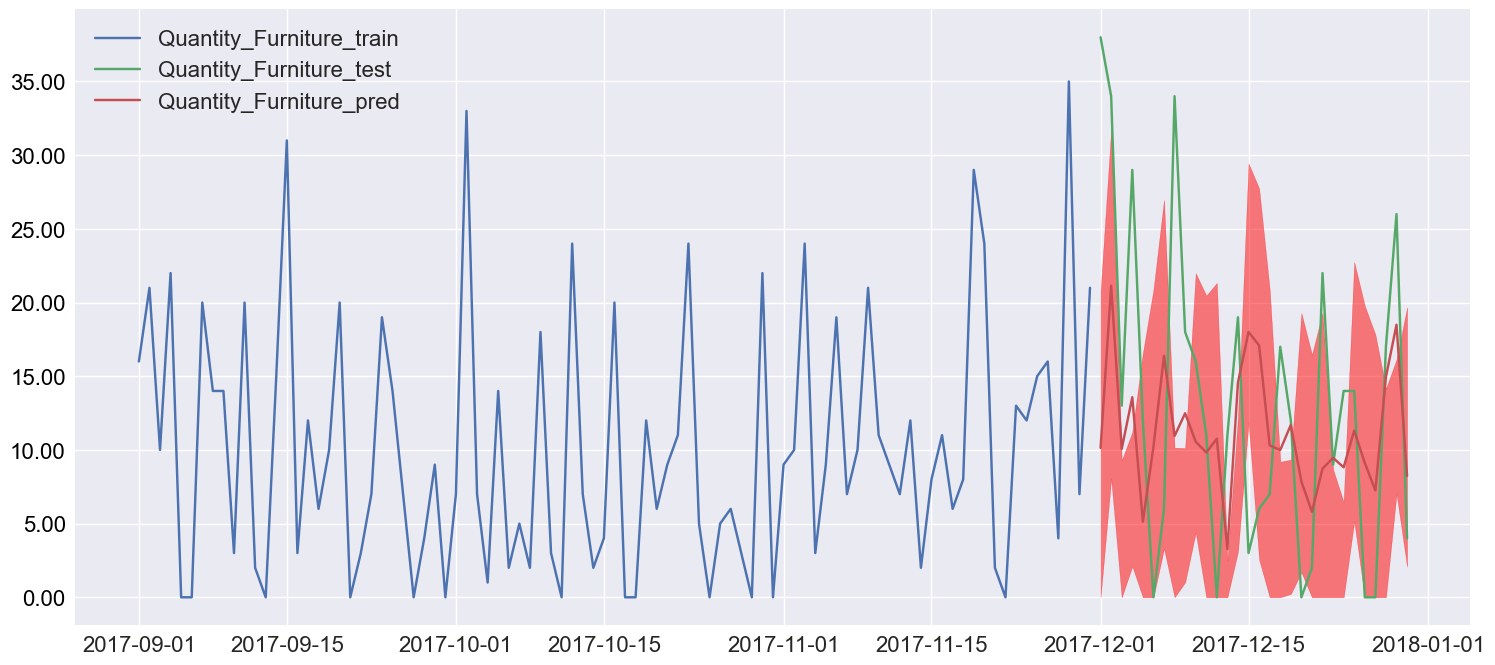

In [50]:
y = ["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
ytrain = y[0]+"_train"
ytest = y[0]+"_test"
ypred = y[0]+"_pred"
error = y[0]+"_pred_error"
dfxgbmv = dfXY_pred_xgbmv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

yfillbetween = (y[0]+"_pred_lower",y[0]+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

**predict multi-output multivariat w/ exogenous and endogenous/derived variablese**

In [51]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfxgbmv.predict(Nperiods=5,dfexogs = dfexogs, ts_period=ts_period)
df_pred

,Quantity_Furniture_pred,Quantity_Office Supplies_pred,Quantity_Technology_pred
2017-12-31,10.260494,51.966106,15.558042
2018-01-01,9.077110,33.470715,11.326902
2018-01-02,7.369271,18.362717,3.324406
2018-01-03,2.566847,13.791990,7.186268
2018-01-04,11.101308,23.151442,9.975344


## 3. TensorFlow Models

### TensorFlow Imports

In [3]:


from sklearn.preprocessing import LabelEncoder


### M5 Sales data, 7 items, data transformation to wide format

M5 Sales 7 Items

In [4]:

df_m5sales7 = pd.read_csv("../data/m5_sales_7_items_events_cci_wide.csv", parse_dates = ["date"])
df_m5sales7 = df_m5sales7.set_index("date")
print("df_m5sales7")
display(df_m5sales7.tail())

# variable types
covars = [c for c in df_m5sales7.columns if "unit_sales_CA1_" in c]
catvars = [ "weekday", "event_name_1","event_name_2"]
exogvars = [ "year", "month" , "week",  "snap_CA",  "CCI_USA"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
dfXY = df_m5sales7[cols].copy()

# label Encoding
le_catvars = [ "le_"+c for c in ["event_name_1","event_name_2"] ] # label encoded category columns ... weekday already encoded
print(le_catvars)
le = LabelEncoder()
dfXY[le_catvars] =dfXY[["event_name_1","event_name_2"] ].apply(le.fit_transform)
weekday_num = {"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6}
dfXY["le_weekday"] = dfXY["weekday"].apply( lambda x: weekday_num[x]) # create our own labels or label_encoder creates arbitrary number assignments
le_catvars = ["le_weekday"] + le_catvars # weekday is alread encoded ... add to le_catvars 
print(f'le_catvars = {le_catvars}')
print(f'N event_name_1 labels = {dfXY.groupby("event_name_1")["event_name_1"].count().index.size}')

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]
print(f'eindim = {eindim}')
print(f'eoutdim = {eoutdim}')

# display dfXY
print(f'dfXY.shape = {dfXY.shape}')
print(f'\ndfXY.head = ')
display(dfXY.head())

df_m5sales7


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,sell_price_CA1_HOUSEHOLD_416,sell_price_CA1_FOODS_044,sell_price_CA1_FOODS_030,...,sell_price_CA1_FOODS_393,year,month,week,weekday,yearmonth,event_name_1,event_name_2,snap_CA,CCI_USA
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Wednesday,201605,NaN,NaN,0,100.7612
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,3.88,2.5,1.48,...,3.56,2016,5,20,Thursday,201605,NaN,NaN,0,100.7612
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Friday,201605,NaN,NaN,0,100.7612
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Saturday,201605,NaN,NaN,0,100.7612
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,3.88,2.5,1.48,...,3.56,2016,5,20,Sunday,201605,NaN,NaN,0,100.7612


['le_event_name_1', 'le_event_name_2']
le_catvars = ['le_weekday', 'le_event_name_1', 'le_event_name_2']
N event_name_1 labels = 30
eindim = [8, 32, 5]
eoutdim = [3, 5, 2]
dfXY.shape = (1206, 18)

dfXY.head = 


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,year,month,week,snap_CA,CCI_USA,le_event_name_1,le_event_name_2,le_weekday
date,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,Saturday,NaN,NaN,2013,2,5,1,98.72734,30,3,6
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,Sunday,SuperBowl,NaN,2013,2,5,1,98.72734,26,3,0
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,Monday,NaN,NaN,2013,2,6,1,98.72734,30,3,1
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,Tuesday,NaN,NaN,2013,2,6,1,98.72734,30,3,2
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,Wednesday,NaN,NaN,2013,2,6,1,98.72734,30,3,3


### Univariate

Univariate Data

In [5]:
# y forecast variable
y = ["unit_sales_CA1_FOODS_030"]

# univariate data
print("dfXYtf univariate")
dfXYtf = dfXY[y] 
display(dfXYtf.tail())

dfXYtf univariate


,unit_sales_CA1_FOODS_030
date,
2016-05-18,7.0
2016-05-19,11.0
2016-05-20,9.0
2016-05-21,9.0
2016-05-22,8.0


TF Model - Dense Network, Univariate

In [8]:
Nlags=5
model_tf_dense = sf.get_dense_nn(Nlags)

Ndense = 5
Nout = 1
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
 dropout_3 (Dropout)         (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 45
Trainable params: 45
N

TF forecast Univariate

In [9]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvtf = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uv = sfuvtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfXYtf.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())


dfXYtf


,unit_sales_CA1_FOODS_030
date,
2016-05-18,7.0
2016-05-19,11.0
2016-05-20,9.0
2016-05-21,9.0
2016-05-22,8.0


1/1 [==============================] - 0s 23ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.485312667646077, 'MAE': 1.9375606536865235}}


,unit_sales_CA1_FOODS_030,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,
2016-05-18,7.0,NaN,7.0,6.312953,-0.687047,1.604142,5.990019
2016-05-19,11.0,NaN,11.0,6.295099,-4.704901,1.586288,5.972164
2016-05-20,9.0,NaN,9.0,6.692428,-2.307572,1.983617,6.369493
2016-05-21,9.0,NaN,9.0,6.930008,-2.069992,2.221197,6.607074
2016-05-22,8.0,NaN,8.0,7.046566,-0.953434,2.337755,6.723632


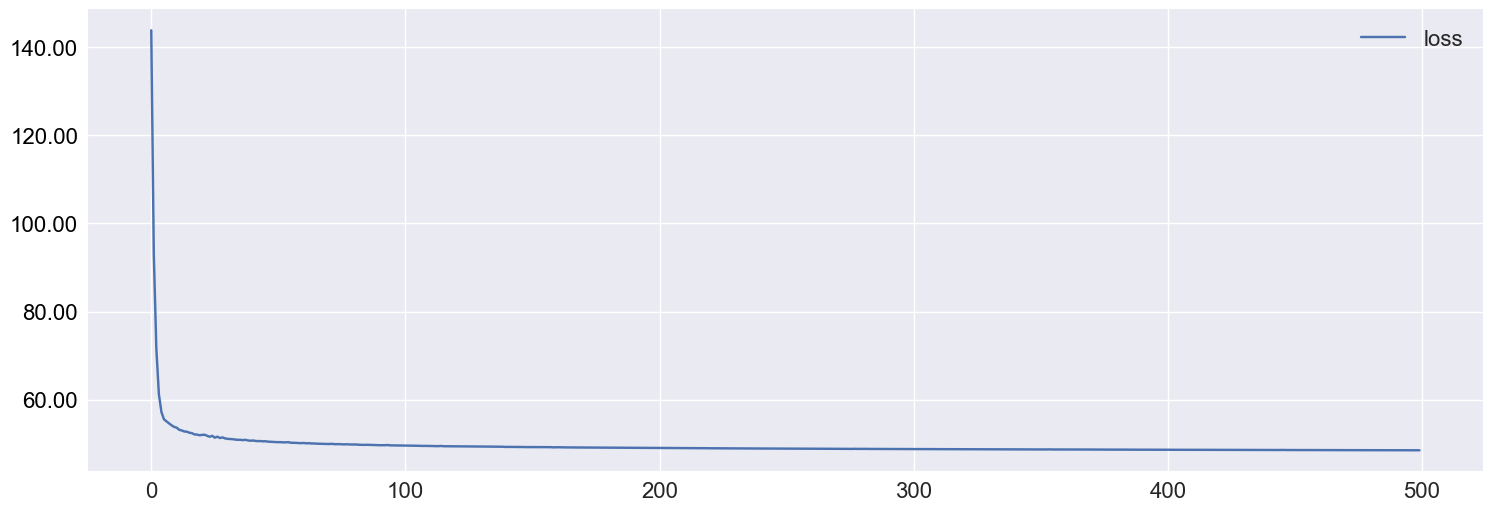

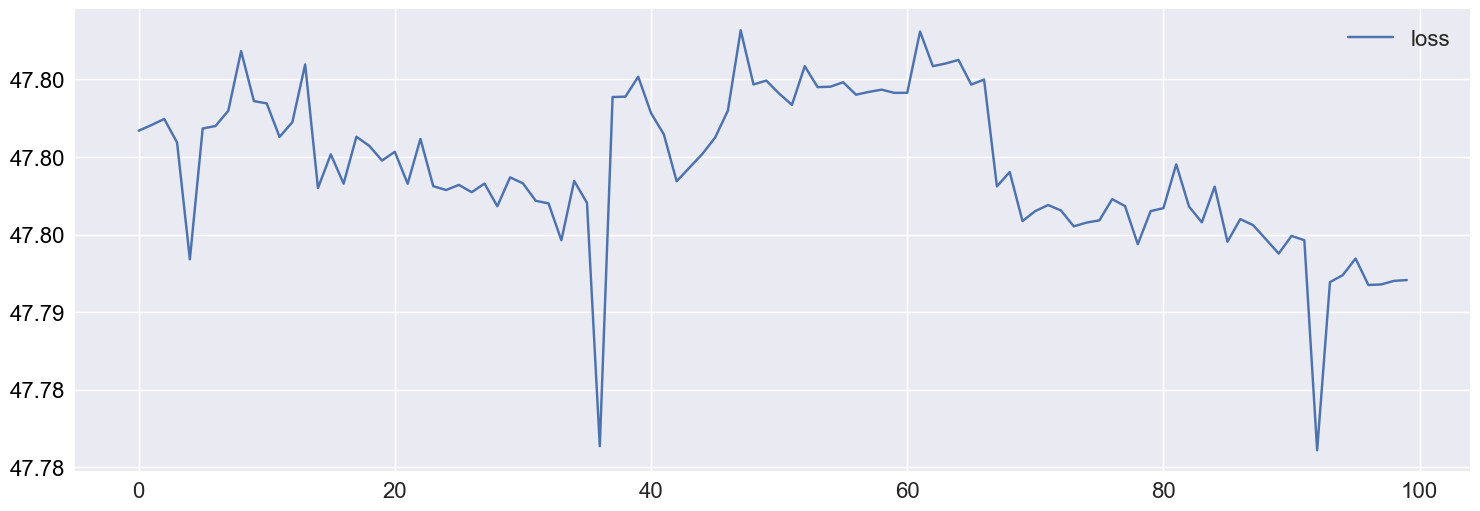

In [8]:
df_loss_i = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_i.history["loss"])), 
                                "loss":sfuvtf.history_i.history["loss"] })
bp.lineplot(df_loss_i, x ="epoch", y = "loss", figsize=(18,6) )

df_loss_t = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_t.history["loss"])), 
                                "loss":sfuvtf.history_t.history["loss"] })
bp.lineplot(df_loss_t, x ="epoch", y = "loss", figsize=(18,6) )

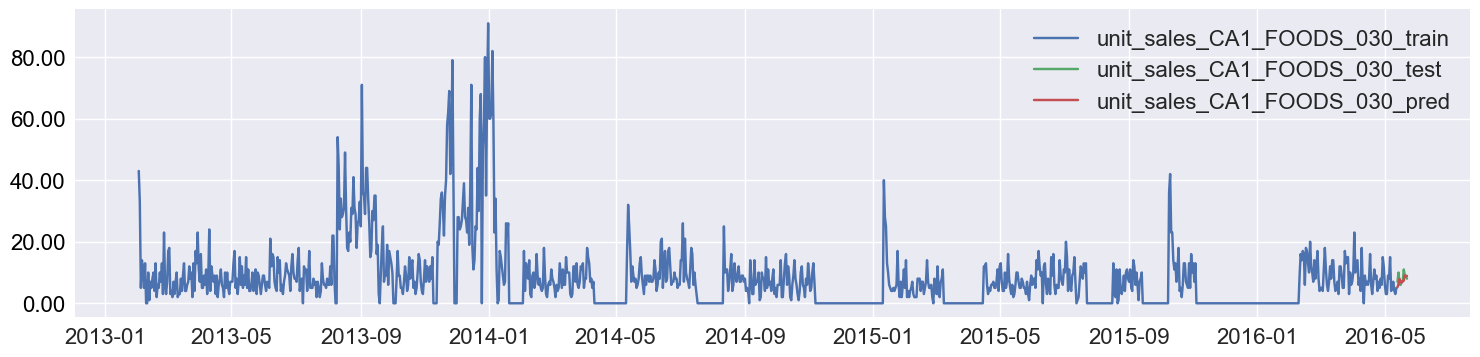

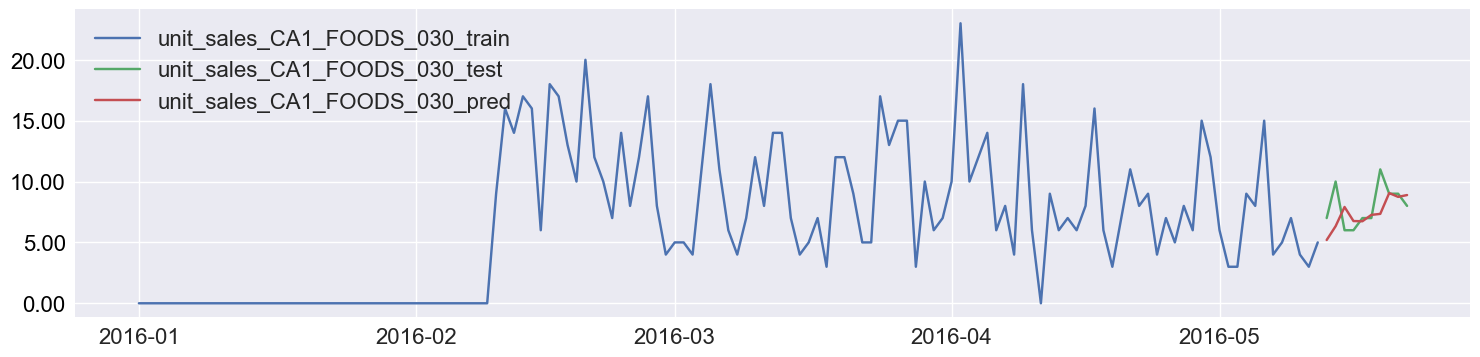

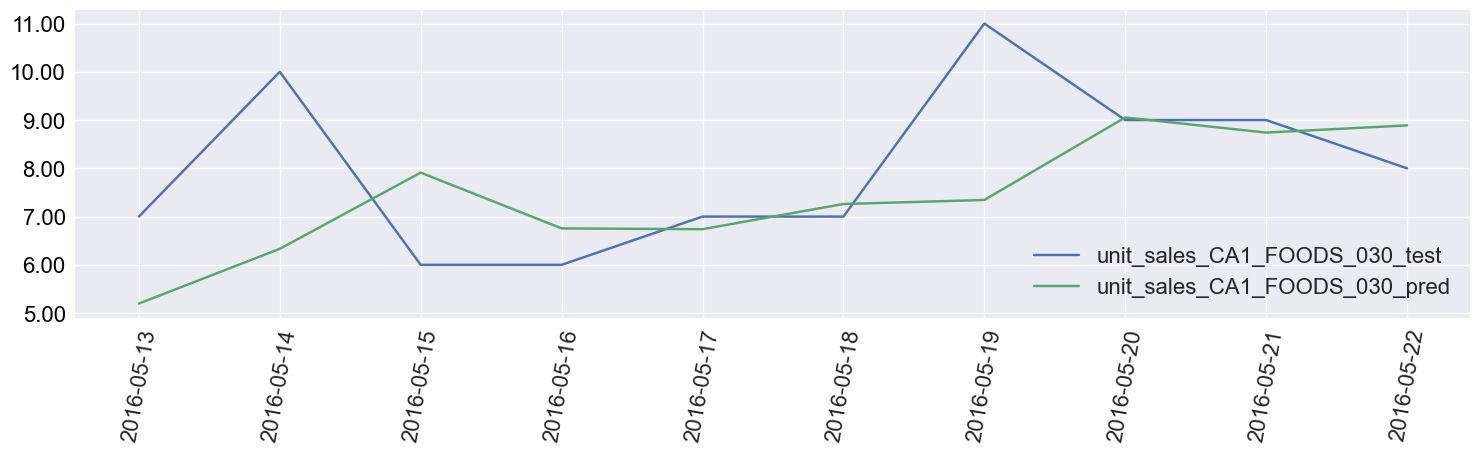

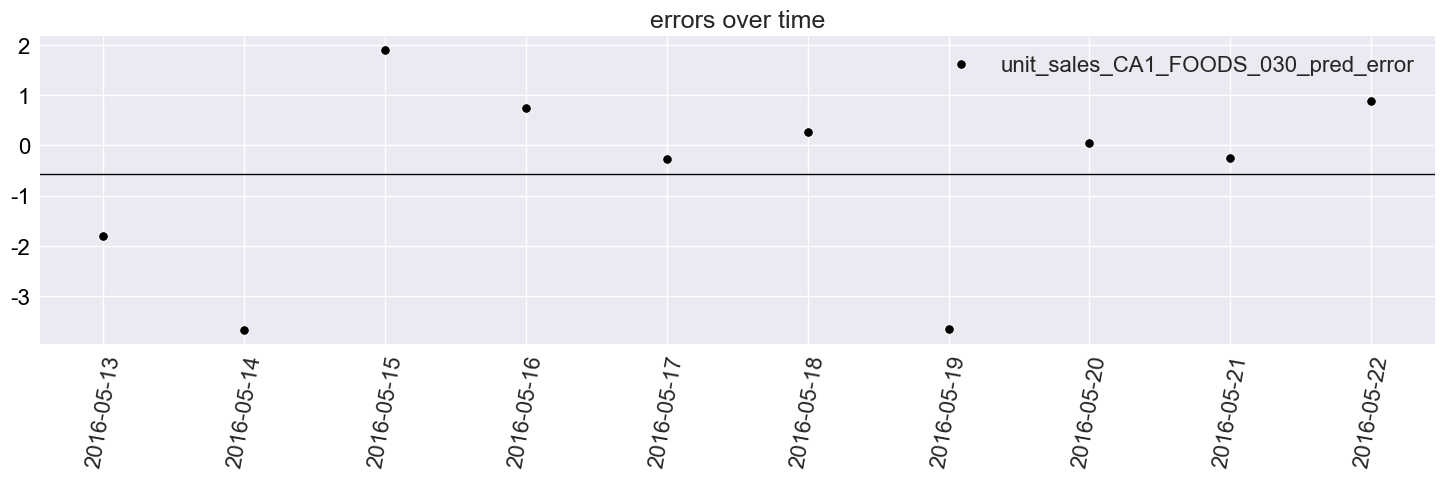

In [9]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

error_avg =df[error].mean()

bp.lineplot(df, x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

d=datetime(2016,1,1)
bp.lineplot(df[df["date"]>=d], x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

bp.lineplot(df.tail(30), x="date", y=[ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

bp.lineplot(df.tail(30), x="date", y=error,  h_line = [error_avg], 
            y_axis_format=".0f",linestyle="None", marker="o", color="k", 
            title = "errors over time", x_tick_rotation=80,  figsize=(18,4))

**Predict TF Univariate**

In [10]:
ts_period = pd.DateOffset(days=1)
#dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfuvtf.predict(Nperiods=3, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 24ms/step


,unit_sales_CA1_FOODS_030_pred
2016-05-23,8.542331
2016-05-24,8.811747
2016-05-25,8.781296


### Multivariate (multiple output NN) with Exogenous, Endogenous, and Categorical

data

In [4]:
# same data as previous multivariate example

dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(le_catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail())

['le_weekday', 'le_event_name_1', 'le_event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


Endogenous (derived) Attributes

In [6]:
# transform dict
# -- transform can be one transform (str) or list
Nrw = 3 # rolling window widith
variable_transform_dict = {
    "unit_sales_CA1_FOODS_030" :["mean","std"],
    "unit_sales_CA1_HOUSEHOLD_416": ["mean","std"],
    "unit_sales_CA1_FOODS_393": ["mean","std"]
}

derived_variables_transformer = sf.rolling_transformer(variable_transform_dict, Nrw=Nrw)

derived_attributes = derived_variables_transformer.get_derived_attribute_names()

Nendogs = len(derived_attributes)

print(f'Nendogs = {Nendogs}')
print()
print(f'derived_attriburtes = {derived_attributes}')



Nendogs = 6

derived_attriburtes = ['unit_sales_CA1_FOODS_030_m1_mean3', 'unit_sales_CA1_FOODS_030_m1_std3', 'unit_sales_CA1_HOUSEHOLD_416_m1_mean3', 'unit_sales_CA1_HOUSEHOLD_416_m1_std3', 'unit_sales_CA1_FOODS_393_m1_mean3', 'unit_sales_CA1_FOODS_393_m1_std3']


NN Exogenous, Endogenous, Categorical MV

In [7]:
Nlags = 5
tf_model_dense_endog_exog_emb_mv = sf.get_dense_emb_nn(dfXYtf, Nlags, le_catvars, Ncovars= Ncovars, Nendogs = Nendogs, Nexogs = Nexogvars)

Ndense = 46
Nemb = 3
Nout = 7
cont_inputs = KerasTensor(type_spec=TensorSpec(shape=(None, 46), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
cat_inputs_list = [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_3')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_4')>]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                          

2024-06-15 07:26:11.657929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:

# display data
y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags": Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_variables_transformer 

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvexen = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=tf_model_dense_endog_exog_emb_mv , tf_parameters=tf_params)

df_pred_mvexen = sfmvexen.fit(dfXYtf)

print(f'\nmetrics = {sfmvexen.metrics}')
dfXY_pred_mvexen = dfXY.join(df_pred_mvexen)
display(dfXY_pred_mvexen.tail())


y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 24ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.387054476973131, 'MAE': 1.8269883871078492}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.310306994306217, 'MAE': 1.131582498550415}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.172020877336241, 'MAE': 3.286684823036194}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,1.343083,-0.656917,0.0,2.750631,NaN,5.0,4.830338,-0.169662,0.0,7.639139
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,1.397539,-0.602461,0.0,2.805087,NaN,8.0,3.988032,-4.011968,0.0,6.796834
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,1.396951,0.396951,0.0,2.804498,NaN,5.0,6.526713,1.526713,0.0,9.335515
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,1.454736,1.454736,0.0,2.862283,NaN,5.0,6.199286,1.199286,0.0,9.008088
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,1.378170,-1.621830,0.0,2.785718,NaN,15.0,6.162971,-8.837029,0.0,8.971772


Plot fit

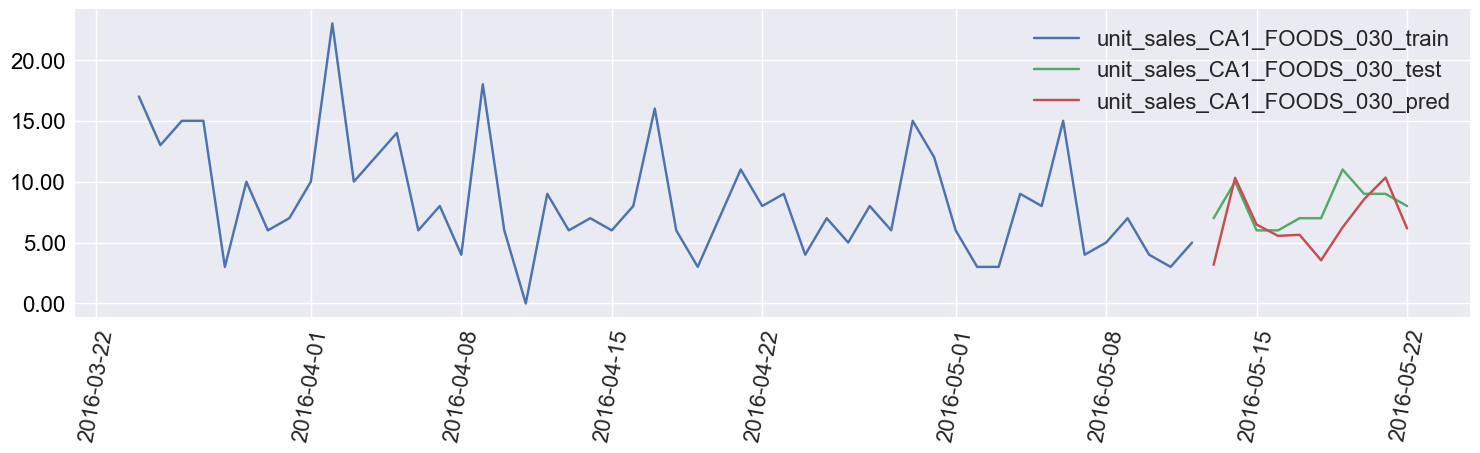

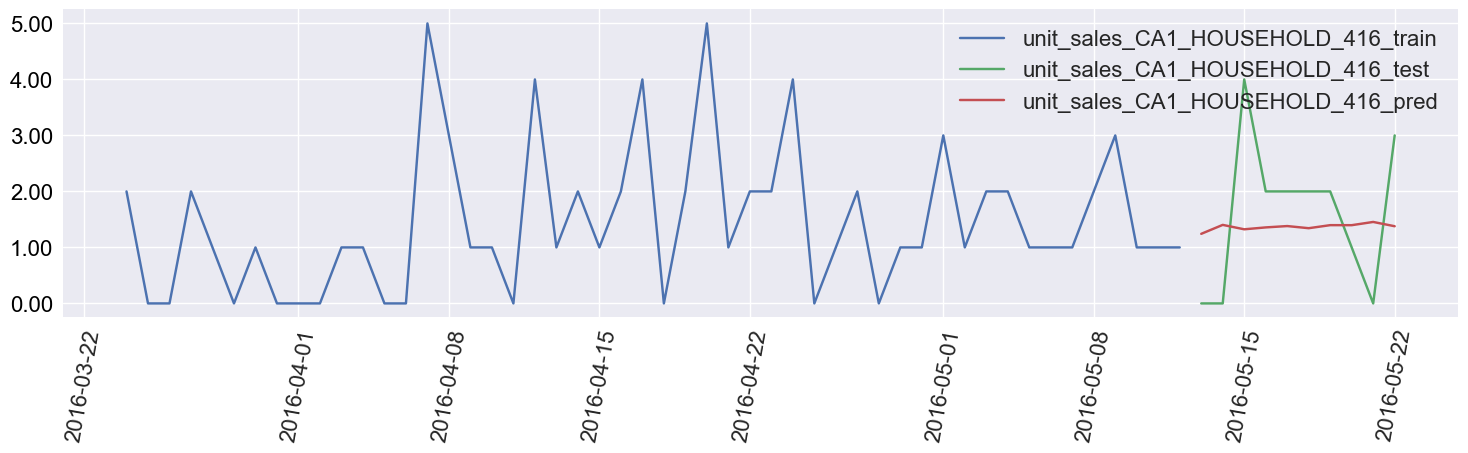

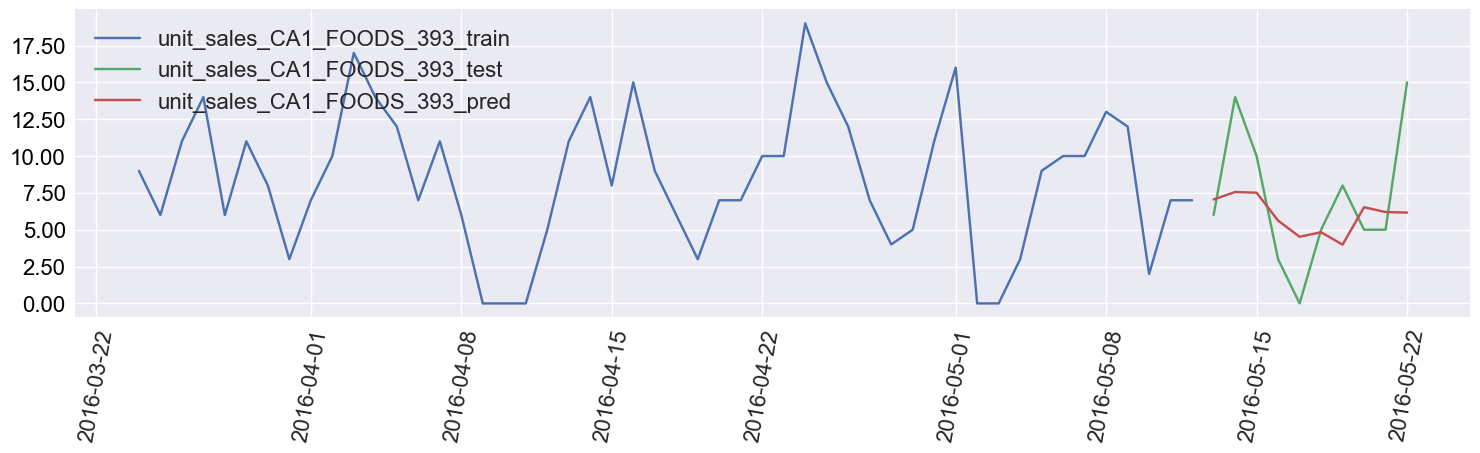

In [9]:
df = dfXY_pred_mvexen.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


predict - exogenous, categorical, endogenous

In [10]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvexen.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,5.384425,1.343881,5.948009
2016-05-24,6.414498,1.386333,5.209722
2016-05-25,5.696672,1.376270,5.636973


### TF Exog Group Routed Directly to NN Output for Linear Combining

In [11]:
#### Data M5 7 items Week
file = "../data/M5_7items_week.csv"
sales_week_7_w = pd.read_csv(file, parse_dates = ["yearweek_dt"]).set_index("yearweek_dt")

### Prepare Data
y = ["unit_sales_FOODS_3_030"]
print(f'target variable = {y}')

# variable types
print("variable types ...")
covars = [c for c in sales_week_7_w.columns if "unit_sales_" in c]
catvars = [ "month", "event_name_1","event_name_2"]
exogvars = [ "yeariso" , "weekiso",  "snap_CA",  "CCI_USA", "sell_price_FOODS_3_030"]
exogs1 = [ "yeariso" , "weekiso",  "snap_CA",  "CCI_USA" ]
exogs2 = ["sell_price_FOODS_3_030"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)
exenvars = [exogs1, exogs2]

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
colsdp = cols  #+ ["yearweek_dt"]
dfXYdp = sales_week_7_w[colsdp].copy()
dfXY = sales_week_7_w[cols].copy()


# label Encoding
le_catvars = [ "le_"+ c for c in catvars ] # label encoded category columns
le = LabelEncoder()
dfXY[le_catvars] = dfXY[catvars].apply(le.fit_transform)

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]

dfXY = dfXY[covars+exogvars+le_catvars]

target variable = ['unit_sales_FOODS_3_030']
variable types ...


In [12]:
### TensorFlow Model
Nlags = 5
Ndense1 = Nlags * Ncovars 
Ndense2 = len(exogs1)
Nlinear = len(exogs2) 
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = Ncovars

#Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
covarlags_in = Input((Ndense1,))
hcovarlags = Dense(Ndense1, activation='relu')(covarlags_in)

exogs1_in = Input((Ndense2,))
hexogs1 = Dense(Ndense2, activation='relu')(exogs1_in)

exogs2_in = Input((Nlinear,))
hexogs2 = Dense(Nlinear)(exogs2_in)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([hcovarlags]+emb_flat_list + [hexogs1] )
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense1 + Nembout + Ndense2 # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# combined to output ... combine the hidden reduced variables and the linear
combined_to_out = concatenate([h2c_d]+[hexogs2])

# output
output = Dense(Nout)(combined_to_out)  # linear activation ... linear combination 
model_tf_dense2_emb_so = Model(inputs=[covarlags_in, exogs1_in, exogs2_in, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense2_emb_so.compile(loss='mse', optimizer=optimizer)

In [13]:
    
# Fit
Ntest = 3
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars,
    "exenvars":exenvars
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sf_tf_dense_emb_so = sf.sliding_forecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense2_emb_so, tf_parameters=tf_params)

df_pred = sf_tf_dense_emb_so.fit(dfXY)

pred_expected =  np.array([50.5, 46.3, 34.5 ])

y_pred = y[0]+"_pred"

pred_expected_p = pred_expected + 10
pred_expected_m = pred_expected - 10
pred_result = df_pred[y_pred].tail(Ntest).values

display(pred_result)

1/1 [==============================] - 0s 30ms/step


array([46.83285522, 46.59129715, 30.99925232])

## Conclusions and Summary

1.  This notebook demonstrates the use of the Sforecast for fitting an ML model within a sliding/expanding window out-of-sample fit (test-train) and for making forward predictictions.  
2. Sforecast supports classical forecast models, SK Learn based models, and TensorFlow models.   
3. The examples demonstrate how to run univariate, and multivariate cases including single output (one forecast target), multiple output (multiple forecast targets), and also handling exogenous, endogenous, and categorical variables.  
4. Sforecast significantly reduces the effort to manipulate data for all of these forecasting scenarios - lagged autoregressive co-variates, forecast horizons, and N-step forecasts.